In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as patches

import os
os.chdir("/Users/deweywang/Desktop/GitHub/HEVisum/")


# Training data preparation 

/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_76949/3787083605.py:55: UserWarning: Glyph 27599 (\N{CJK UNIFIED IDEOGRAPH-6BCF}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0,0,1,0.97])
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_76949/3787083605.py:55: UserWarning: Glyph 24352 (\N{CJK UNIFIED IDEOGRAPH-5F20}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0,0,1,0.97])
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_76949/3787083605.py:55: UserWarning: Glyph 19978 (\N{CJK UNIFIED IDEOGRAPH-4E0A}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0,0,1,0.97])
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_76949/3787083605.py:55: UserWarning: Glyph 38543 (\N{CJK UNIFIED IDEOGRAPH-968F}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0,0,1,0.97])
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_76949/3787083605.py:55: UserWarning: Glyph 26426 (\N{CJK UNIFIED IDEOGRAPH-673A}) missing

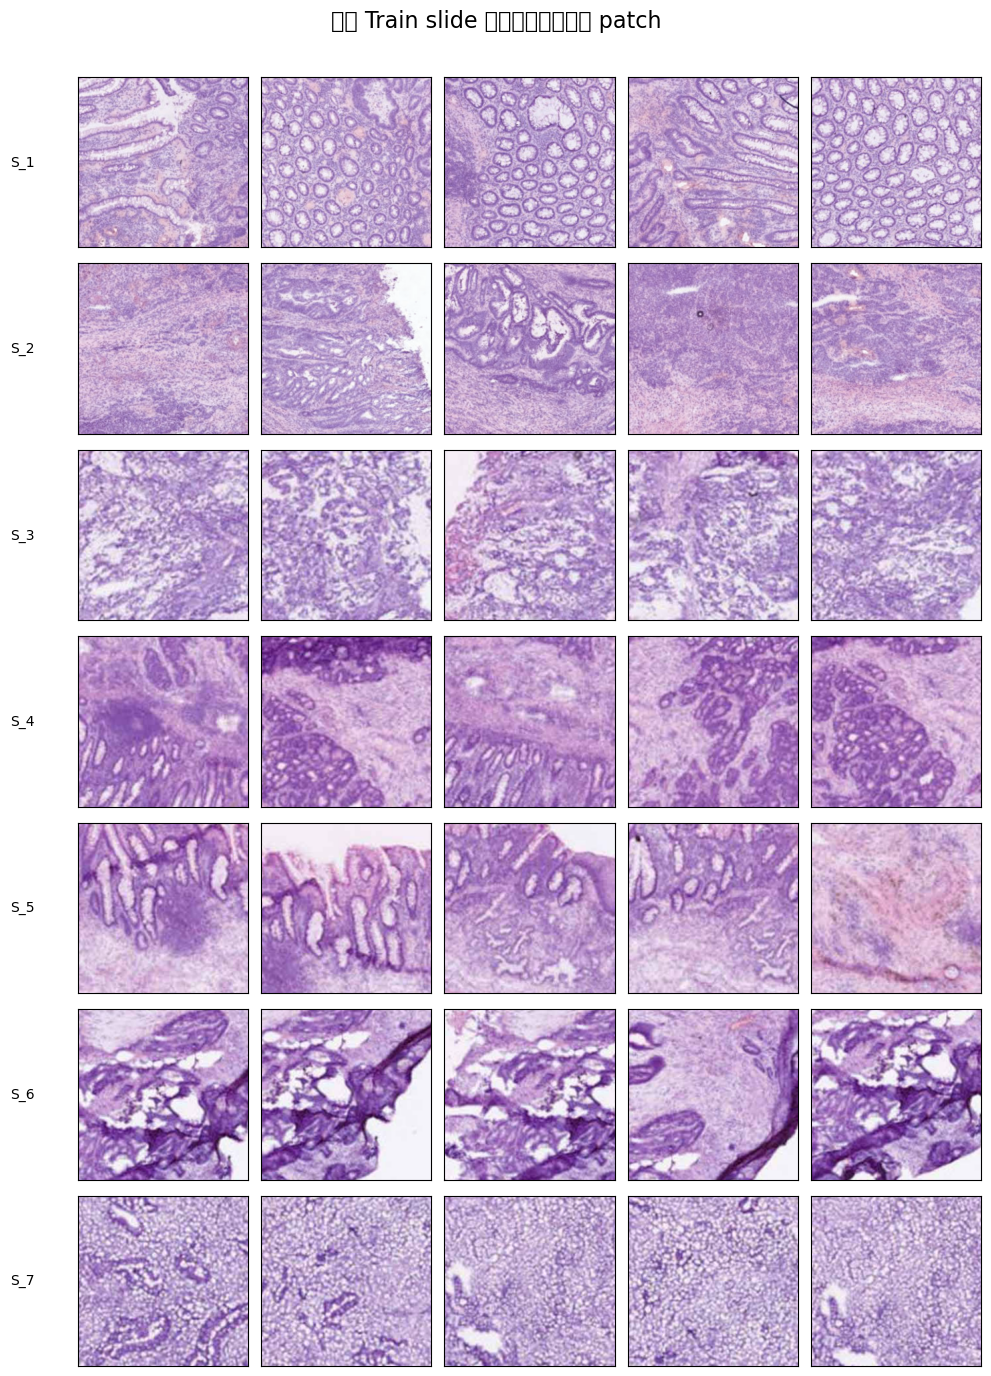

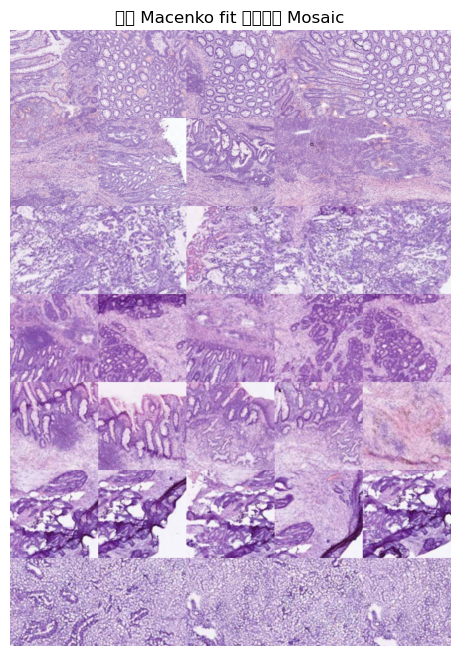

/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_76949/3787083605.py:117: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_76949/3787083605.py:117: UserWarning: Glyph 22270 (\N{CJK UNIFIED IDEOGRAPH-56FE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_76949/3787083605.py:117: UserWarning: Glyph 24402 (\N{CJK UNIFIED IDEOGRAPH-5F52}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_76949/3787083605.py:117: UserWarning: Glyph 19968 (\N{CJK UNIFIED IDEOGRAPH-4E00}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_76949/3787083605.py:117: UserWarning: Glyph 21270 (\N{CJK UNIFIED IDEOGRAPH-5316}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


✅ Train/S_1 归一化并写入完成
✅ Train/S_2 归一化并写入完成
✅ Train/S_3 归一化并写入完成
✅ Train/S_4 归一化并写入完成
✅ Train/S_5 归一化并写入完成
✅ Train/S_6 归一化并写入完成
✅ Test/S_7 归一化并写入完成

🎉 新的归一化 HDF5 已保存到：./dataset/try.h5


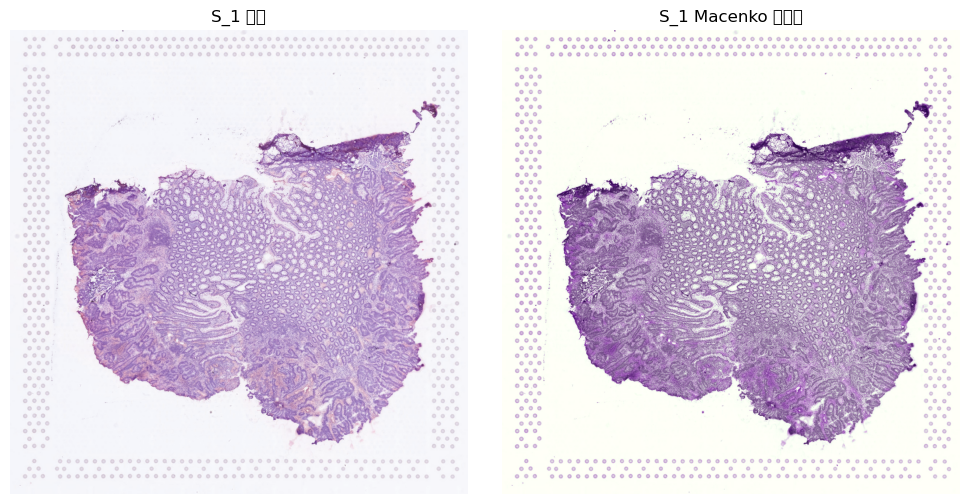

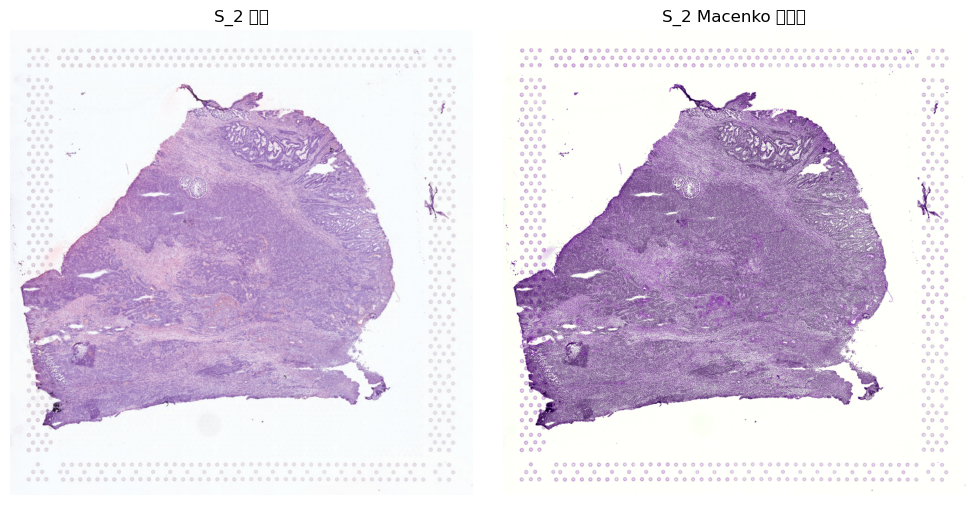

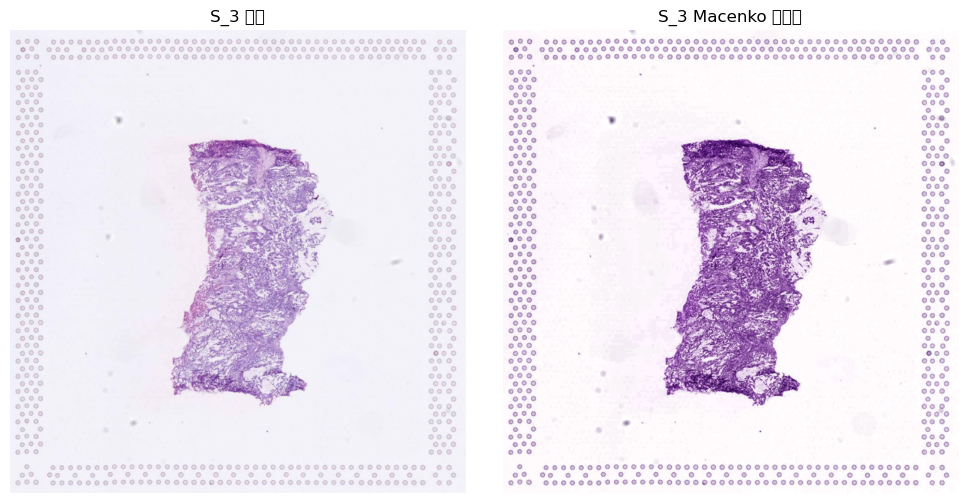

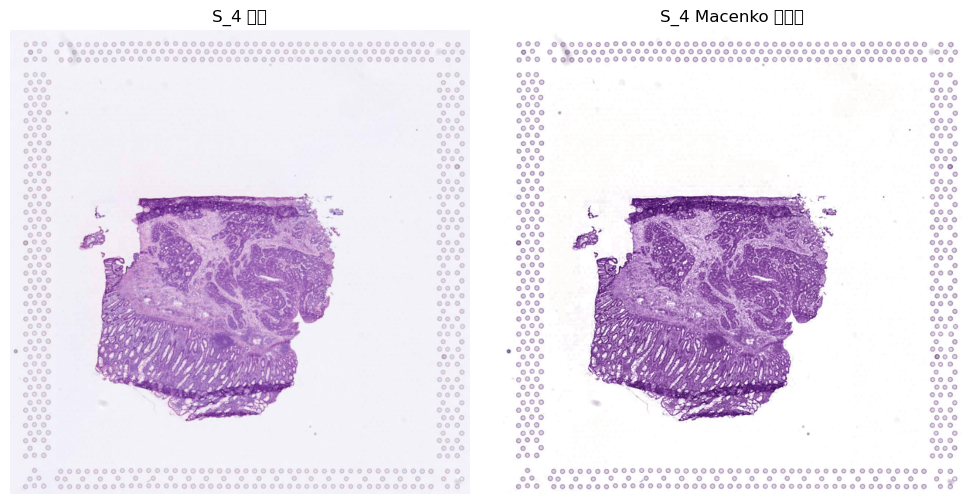

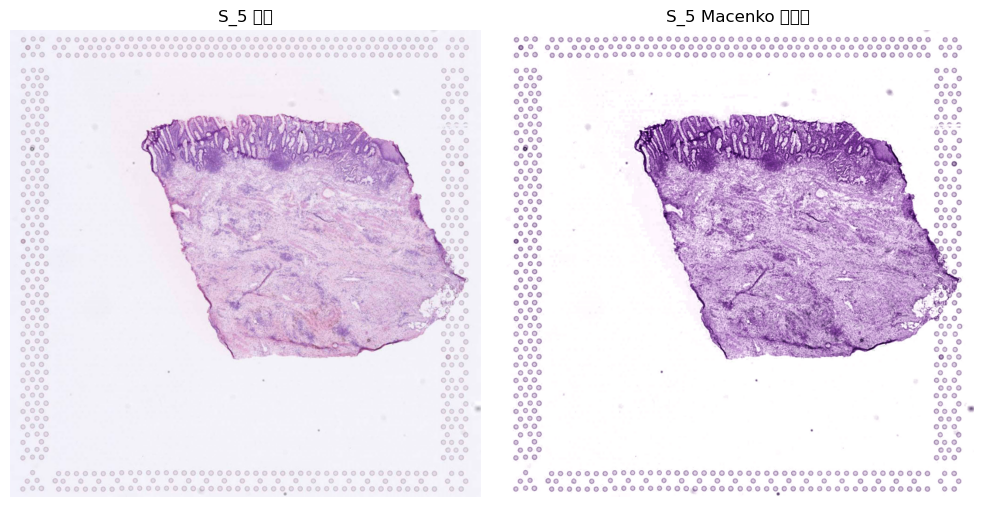

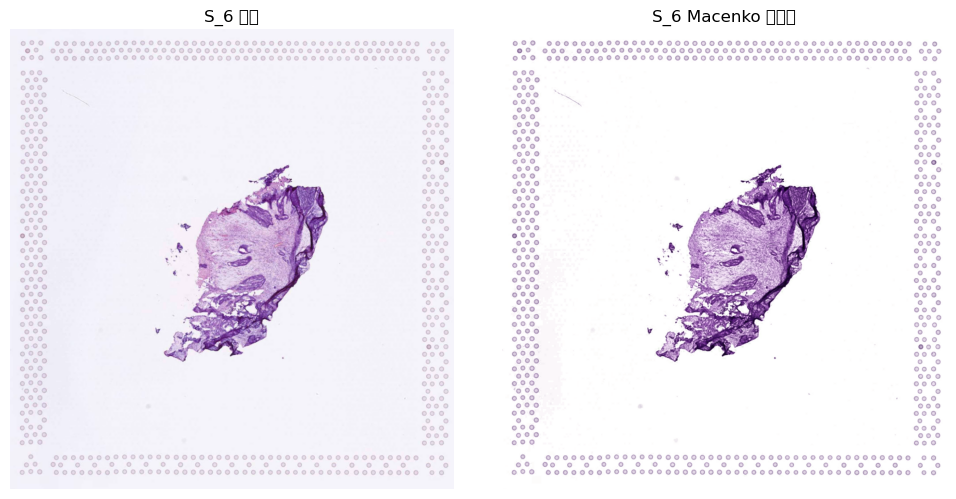

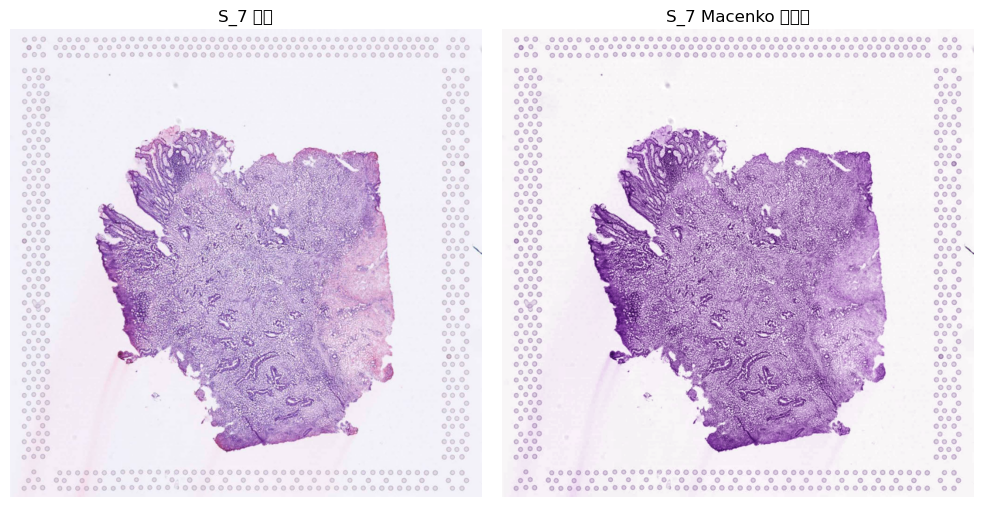

In [ ]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
import torchstain
from scripts.image_preprocessing import make_tissue_mask, sample_tissue_patches_np, normalize_np_image

# -----------------------------------------------------------------------------
# 1) Read all Train slides from HDF5 and sample patches
# -----------------------------------------------------------------------------
src_path = "./dataset/elucidata_ai_challenge_data.h5"
patch_size     = 256
n_patches      = 5
min_frac       = 0.6
seed           = 46
# wanted = {"S_7", "S_6","S_4", "S_5"}
wanted = {"S_1", "S_2", "S_3","S_4", "S_5" , "S_6", "S_7"}
all_patches = {}  # slide_id -> list of patches



with h5py.File(src_path, "r") as h5:
    for split in ["Train", "Test"]:
        train_grp = h5[f"images/{split}"]
        for sid in sorted(train_grp.keys()):
            if sid not in wanted:
                continue   
            img = np.array(train_grp[sid], dtype=np.float32)  # [0,1]
            mask = make_tissue_mask(img, thresh=0.8)
            patches = sample_tissue_patches_np(
                img, mask,
                patch_size=patch_size,
                n_patches=n_patches,
                min_frac=min_frac,
                seed=seed
            )
            all_patches[sid] = patches

# -----------------------------------------------------------------------------
# 2) Display sampled patches in a grid per slide
# -----------------------------------------------------------------------------
n_slides = len(all_patches)
fig, axes = plt.subplots(
    n_slides, n_patches,
    figsize=(n_patches*2, n_slides*2),
    squeeze=False
)

for i, (sid, patches) in enumerate(all_patches.items()):
    for j, patch in enumerate(patches):
        ax = axes[i][j]
        ax.imshow((patch*255).astype(np.uint8))
        ax.set_xticks([]); ax.set_yticks([])
        if j == 0:
            ax.set_ylabel(sid, rotation=0, labelpad=40, va="center")
plt.suptitle("每张 Train slide 上随机采样的组织 patch", fontsize=16)
plt.tight_layout(rect=[0,0,1,0.97])
plt.show()


# -----------------------------------------------------------------------------
# 3) Concatenate all patches horizontally into one large image
# -----------------------------------------------------------------------------

rows = []
for sid, patches in all_patches.items():
    row = np.hstack([(p*255).astype(np.uint8) for p in patches])
    rows.append(row)
big_ref = np.vstack(rows)  # uint8 [0,255]

# 3) 转 Tensor，不要再 *255
to_tensor255 = transforms.Compose([
    transforms.ToTensor(),          # H×W×3 uint8→C×H×W float [0,1]
    transforms.Lambda(lambda t: t*255)  # →[0,255]
])
template_t = to_tensor255(big_ref)   # shape [3,H,W], values in [0,255]

normalizer = torchstain.normalizers.MacenkoNormalizer(backend="torch")
normalizer.fit(template_t)

# 2) （可选）展示一下拼出的参考图
plt.figure(figsize=(8,8))
plt.imshow(big_ref)
plt.axis("off")
plt.title("用于 Macenko fit 的大参考 Mosaic")
plt.show()


# -----------------------------------------------------------------------------
# 4) Normalize all slides and write to new HDF5 (same group structure)
# -----------------------------------------------------------------------------
src_path = "./dataset/elucidata_ai_challenge_data.h5"
dst_path = "./dataset/try.h5"
os.makedirs(os.path.dirname(dst_path), exist_ok=True)

with h5py.File(src_path, "r") as src, \
     h5py.File(dst_path, "w") as dst:

    for split in ["Train", "Test"]:
        grp_in  = src[f"images/{split}"]
        grp_out = dst.create_group(f"images/{split}")

        for slide_id in grp_in.keys():
            # 读原图 [0,1]
            img = np.array(grp_in[slide_id], dtype=np.float32)
            # 用 torchstain 归一化，得 uint8 [0,255]
            norm_u8 = normalize_np_image(img,to_tensor_fn= to_tensor255, normalizer = normalizer )
            # 再转回 float32 [0,1]
            norm_f = norm_u8.astype(np.float32) / 255.0
            # 绘图
            fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))
            ax0.imshow((img * 255).astype(np.uint8))
            ax0.set_title(f"{slide_id} 原图")
            ax0.axis("off")
            ax1.imshow(norm_u8)
            ax1.set_title(f"{slide_id} Macenko 归一化")
            ax1.axis("off")
            plt.tight_layout()
            # 写入新文件，开启 gzip 压缩
            grp_out.create_dataset(
                name=slide_id,
                data=norm_f
            )
            print(f"✅ {split}/{slide_id} 归一化并写入完成")

print(f"\n🎉 新的归一化 HDF5 已保存到：{dst_path}")
